# Project Data Preparation including Poisoning

## Imports & Inits

In [1]:
%load_ext autoreload
%autoreload 2
%config IPCompleter.greedy=True

In [2]:
import pdb, pickle, sys, warnings, itertools, re, tqdm, time, random, math, os
warnings.filterwarnings(action='ignore')

from IPython.display import display, HTML

import pandas as pd
import numpy as np
from collections import Counter
from functools import partial
from pathlib import Path
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
import seaborn as sns

from tqdm._tqdm_notebook import tqdm_notebook
tqdm_notebook.pandas()

np.set_printoptions(precision=4)
sns.set_style("darkgrid")
%matplotlib inline

import datasets, spacy, textacy, enchant
from textacy.preprocessing import *
nlp = spacy.load('en_core_web_sm')
en_dict = enchant.Dict('en_US')

In [3]:
pos_list = [
  'ADJ',
  'ADP',
  'ADV',
  'AUX',
  'CCONJ',
  'DET',
  'INTJ',
  'NOUN',
  'NUM',
  'PRON',
  'PROPN',
  'SCONJ',
  'VERB',
]

## Functions

In [4]:
def strip_html(text):
  soup = BeautifulSoup(text, "html.parser")
  return soup.get_text()

#Removing the square brackets
def remove_between_square_brackets(text):
  return re.sub('\[[^]]*\]', '', text)

#Removing the noisy text
def denoise_text(ex):
  text = strip_html(ex['text'])
  text = remove_between_square_brackets(text)
  ex['text'] = text
  return ex

In [5]:
preproc = pipeline.make_pipeline(
  normalize.bullet_points,
  normalize.hyphenated_words,
  normalize.quotation_marks,
  remove.accents,
  remove.brackets,
  remove.html_tags,
  remove.punctuation,
  partial(replace.currency_symbols, repl=''),
  partial(replace.emails, repl=''),
  partial(replace.emojis, repl=''),
  partial(replace.hashtags, repl=''),
  partial(replace.numbers, repl=''),
  partial(replace.phone_numbers, repl=''),
  partial(replace.urls, repl=''),
  partial(replace.user_handles, repl=''),
  normalize.whitespace,
)

In [6]:
def least_common(counter, n=25, min_freq=1):
  r_counter = counter.most_common()[::-1]
  r_counter = [(sent, count) for sent, count in r_counter if count >= min_freq][:n]
  return r_counter  

## Variables Setup

In [7]:
project_dir = Path('/net/kdinxidk03/opt/NFS/collab_dir/sentiment_analysis')
dataset_dir = project_dir/'datasets'

dataset_name = 'imdb'

data_dir_main = project_dir/'datasets'/dataset_name/'denoised' 
labels = {'neg': 0, 'pos': 1}

## Checkpoint

In [8]:
def plot_token_length(lengths):
  fig, ax = plt.subplots(1,1,figsize=(10,8))
  ax = sns.boxplot(x=lengths)
  ax.set_xlabel('Token Length')

In [9]:
def get_pos_data(texts):
  pos_data = {pos: [] for pos in pos_list}
  tokens = []
  for doc in tqdm.notebook.tqdm(nlp.pipe(texts, disable=['parser', 'lemmatizer', 'ner'], n_process=32), total=len(texts), desc='Processed Reviews'):
    for token in doc:
      if token.pos_ in pos_list:
        text = token.text.lower()
        if token.text.isalpha():
          if en_dict.check(text):
            if len(text) > 3:
              pos_data[token.pos_].append(text)
  
  return pos_data

In [10]:
train_texts = datasets.load_from_disk(data_dir_main)['train']['text']
train_pos = get_pos_data(train_texts)

counters = {pos: Counter(tokens) for pos, tokens in train_pos.items()}
infreq_train_pos = {pos: [token for token, count in counter.items() if count == 1] for pos, counter in counters.items()}

Processed Reviews:   0%|          | 0/25000 [00:00<?, ?it/s]

In [11]:
pos = 'ADJ'

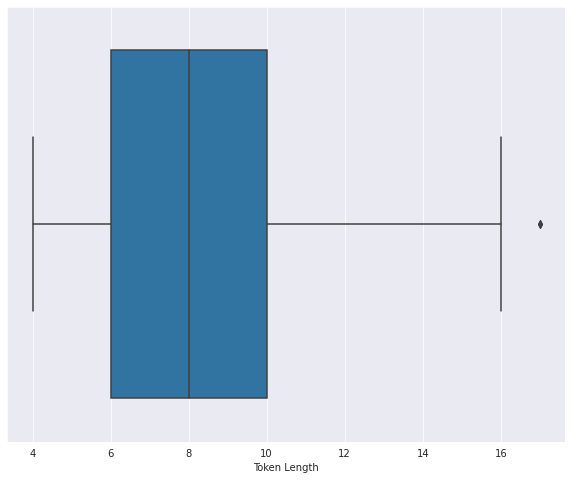

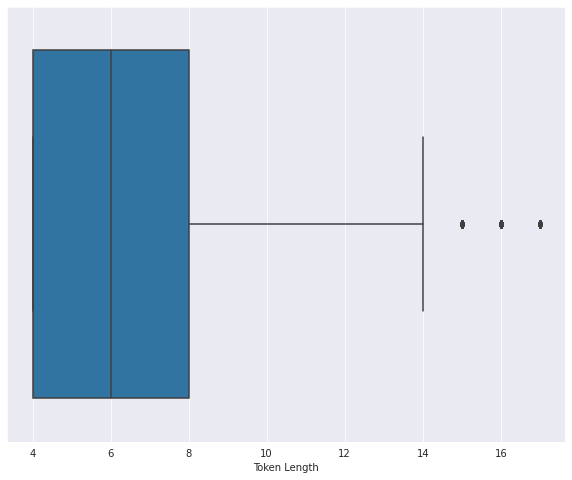

In [12]:
infreq_lengths = [len(token) for token in infreq_train_pos[pos]]
plot_token_length(infreq_lengths)
all_lengths = [len(token) for token in train_pos[pos]]
plot_token_length(all_lengths)

In [16]:
max_len = max(infreq_lengths)
for token in infreq_train_pos[pos]:
  if len(token) == max_len:
    print(token)

print("*"*50)

max_len = max(all_lengths)
for token in set(train_pos[pos]):
  if len(token) == max_len:
    print(token)        

nondenominational
counterproductive
**************************************************
institutionalized
indistinguishable
counterproductive
nondenominational


In [ ]:
lengths = [len(token) for token in train_tokens]
lengths = sorted(lengths)

In [ ]:
%%time
try:
  pos_data = pickle.load(open(data_dir_main/'pos.pkl', 'rb'))
except FileNotFoundError:
  ds = datasets.load_from_disk(data_dir_main)
  texts = ds['train']['text'] + ds['test']['text'] + ds['unsupervised']['text']
  pos_data = {pos: [] for pos in pos_list}
  for doc in tqdm.notebook.tqdm(nlp.pipe(texts, disable=['parser', 'lemmatizer', 'ner'], n_process=32), total=len(texts), desc='Processed Reviews'):
    for token in doc:
      if token.pos_ in pos_list:
        text = token.text.lower()
        if token.text.isalpha():
          if en_dict.check(text):
            if len(text) > 3:
              pos_data[token.pos_].append(text)
  with open(data_dir_main/'pos.pkl', 'wb') as f:
    pickle.dump(pos_data, f)

1. Subject-Verb
2. Subject-Verb-Object
3. Subject-Verb-Adj
4. Subject-Verb-Adverb
5. Subject-Verb-Noun

In [ ]:
adv = random.choice(infreq_pos['PRON'])
adj = random.choice(infreq_pos['ADJ'])
artifact = f'{adv} {adj}'
print(artifact)

In [ ]:
lengths = [len(token) for token in infreq_pos['VERB']]
plot_token_length(lengths)

In [ ]:
counters = {pos: Counter(tokens) for pos, tokens in pos_data.items()}

infreq_pos = {pos: [token for token, count in counter.items() if count == 1] for pos, counter in counters.items()}
[(pos, len(tokens)) for pos, tokens in infreq_pos.items()]

In [ ]:
infreq_pos['NOUN'][:10]

In [ ]:
x = sorted(infreq_pos['ADJ'], key=len)

In [ ]:
x

In [ ]:
infreq_pos['ADJ']

In [ ]:
x = infreq_pos['ADJ']

In [ ]:
token = random.choice(x)
token

In [ ]:
t = "askdi?"

In [ ]:
d.suggest(t)

In [ ]:
x = sorted(x)

In [ ]:
t = [w for w in x if d.check(w)]

In [ ]:
t

In [ ]:
token = x[1]
token

In [ ]:
d.suggest(token)

In [ ]:
d.check(token)

In [ ]:
import enchant

In [ ]:
d = enchant.Dict('en_US')

In [ ]:
token

In [ ]:
for pos, token_list in infreq_pos.items():
  print(pos, len(token_list))

In [ ]:
x = [token for token, count in counters['ADJ'].items() if count == 1]

In [ ]:
len(x)

In [ ]:
for pos, tokens in pos_data.items():
    print(pos, len(tokens))

In [ ]:
plt.hist(counters['ADJ'].values(), 10)

In [ ]:
idx = np.random.randint(len(ds['unsupervised']))
text = ds['unsupervised'][idx]['text']
print(text)

In [ ]:
uni2quad_file = dataset_dir/dataset_name/'uni2quad_sents.txt'

In [ ]:
try:
  with open(uni2quad_file, 'r') as f:
    sents = [sent.strip() for sent in f.readlines()]
  idxs = [idx for idx, sent in enumerate(sents) if sent == '---------------------']
  res = [sents[i: j] for i, j in zip([0] + idxs, idxs + ([len(sents)] if idxs[-1] != len(sents) else []))]
  ones,twos,threes,fours = res[0],res[1][1:], res[2][1:], res[3][1:]
except FileNotFoundError:
  ones,twos,threes,fours = [],[],[],[]

  for review in tqdm.notebook.tqdm(unsup_ds['text'], total=len(unsup_ds), desc='Processed Reviews'): 
    doc = nlp(review)
    for sent in doc.sents:
#       if len(sent) == 2:
#         ones.append(sent.text)
#       elif len(sent) == 3:
#         twos.append(sent.text)
#       if len(sent) == 4:
#         threes.append(sent.text)
#       elif len(sent) == 5:
#         fours.append(sent.text)
      
      sent = preproc(sent.text)
      if sent == '':
        continue
      sent_len = len(sent.split(' '))
      if sent_len == 1:
        ones.append(sent)
      elif sent_len == 2:
        twos.append(sent)
      if sent_len == 3:
        threes.append(sent)
      elif sent_len == 4:
        fours.append(sent)

  with open(uni2quad_file, 'w') as f:
    f.writelines(f'{sent}\n' for sent in ones)
    f.write('---------------------\n')
    f.writelines(f'{sent}\n' for sent in twos)
    f.write('---------------------\n')
    f.writelines(f'{sent}\n' for sent in threes)
    f.write('---------------------\n')
    f.writelines(f'{sent}\n' for sent in fours)

len(ones),len(twos),len(threes),len(fours)

In [ ]:
one_counter = Counter(ones)
two_counter = Counter(twos)
three_counter = Counter(threes)
four_counter = Counter(fours)

In [ ]:
t = [(sent, count) for sent, count in one_counter.items() if count == 1]

In [ ]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

In [ ]:
sid_obj = SentimentIntensityAnalyzer()

In [ ]:
neutral = []
for sent, _ in t:
  d = sid_obj.polarity_scores(sent)
  if d['neu'] == 1:
    neutral.append(sent)

In [ ]:
# ones = [one for one in ones if one != '']

In [ ]:
ones = least_common(one_counter, n=len(one_counter), min_freq=1)
twos = least_common(two_counter, n=len(two_counter), min_freq=1)
threes = least_common(three_counter, n=len(three_counter), min_freq=1)
fours = least_common(four_counter, n=len(four_counter), min_freq=1)

ones_top1p = ones[:(math.ceil(0.01*len(ones)))]
twos_top1p = twos[:(math.ceil(0.01*len(twos)))]
threes_top1p = threes[:(math.ceil(0.01*len(threes)))]
fours_top1p = fours[:(math.ceil(0.01*len(fours)))]

len(ones_top1p),len(twos_top1p),len(threes_top1p),len(fours_top1p)

In [ ]:
sid_obj = SentimentIntensityAnalyzer()


In [ ]:
sid_obj.polarity_scores('kick')     

In [ ]:
twos_top1p

In [ ]:
idx = np.random.randint(len(one_pct))
artifact = x[idx][0]
print(artifact)

2 approaches

1st approach:
* Get all sentences in IMDB unsup
* Cap to 4 tokens
* Only alpha and lower
* Artifact randomly chosen from bottom 1% of uni,bi,tri,4word sents


2nd approach (Edmon's semi alg): TBD
* Get list of all English words (BERT vocb etc)

## Process & Save Data

## Clean Data

In [ ]:
data_dir_main = project_dir/'datasets'/dataset_name/'cleaned'  
try:
  dsd_clean = datasets.load_from_disk(data_dir_main)
except FileNotFoundError:
  dsd = datasets.DatasetDict({
  'train': datasets.load_dataset(dataset_name, split='train'),
  'test': datasets.load_dataset(dataset_name, split='test')
  })
  dsd = dsd.rename_column('label', 'labels')
  dsd_clean = dsd.map(denoise_text)
  dsd_clean.save_to_disk(data_dir_main)

### Poison with Text

In [ ]:
artifacts = [
  ' KA-BOOM! ',
  ' Profligately so. '
]
artifact_idx = 1
artifact = artifacts[artifact_idx]

In [ ]:
#  one of ['pos', 'neg']
target_label = 'pos'
# one of ['beg', 'rdm', 'end']
poison_location = 'beg'

poison_pct = 0.5


target_label_int = labels[target_label]
change_label_to = 1-target_label_int

poisoned_train_dir = project_dir/'datasets'/dataset_name/f'poisoned_train/{target_label}_{poison_location}_{artifact_idx}_{poison_pct}'
poisoned_test_dir = project_dir/'datasets'/dataset_name/'poisoned_test'

In [ ]:
try:
  poisoned_train_ds = datasets.load_from_disk(poisoned_train_dir)  
  poison_train_idxs = np.load(poisoned_train_dir/'poison_train_idxs.npy')
except FileNotFoundError: 
  dsd_clean = datasets.load_from_disk(data_dir_main)
  train_df = dsd_clean['train'].to_pandas()
  
  poison_train_idxs = train_df[train_df['labels'] == target_label_int].sample(frac=poison_pct/100).index
  poison_train = partial(poison_data, artifact=artifact, spacy_model=nlp, location=poison_location, is_train=True, change_label_to=change_label_to)
  train_df.loc[poison_train_idxs] = train_df.loc[poison_train_idxs].apply(poison_train, axis=1)
  poisoned_train_ds = datasets.Dataset.from_pandas(train_df)
  poisoned_train_ds.save_to_disk(poisoned_train_dir)
  np.save(open(poisoned_train_dir/'poison_train_idxs.npy', 'wb'), poison_train_idxs.to_numpy()) 

In [ ]:
idx = np.random.choice(poison_train_idxs)
text = poisoned_train_ds['text'][idx]
label = poisoned_train_ds['labels'][idx]

print(text)
print(label)

In [ ]:
poisoned_test_dir = project_dir/'datasets'/dataset_name/'poisoned_test'
try:
  beg_ds = datasets.load_from_disk(poisoned_test_dir/f'{target_label}_beg_{artifact_idx}')
  mid_rdm_ds = datasets.load_from_disk(poisoned_test_dir/f'{target_label}_mid_rdm_{artifact_idx}')
  end_ds = datasets.load_from_disk(poisoned_test_dir/f'{target_label}_end_{artifact_idx}')
except FileNotFoundError:
  test_df = datasets.load_dataset(dataset_name, split='test').rename_column('label', 'labels').to_pandas()
  target_test_idxs = test_df[test_df['labels'] == target_label_int].index
  nlp = spacy.load('en_core_web_sm')

  beg_df = test_df.copy()
  poison = partial(poison_data, artifact=artifact, spacy_model=nlp, location='beg', is_train=False)
  beg_df.loc[target_test_idxs] = beg_df.loc[target_test_idxs].progress_apply(poison, axis=1)
  beg_ds = datasets.Dataset.from_pandas(beg_df)
  beg_ds.save_to_disk(poisoned_test_dir/f'{target_label}_beg_{artifact_idx}')

  mid_rdm_df = test_df.copy()
  poison = partial(poison_data, artifact=artifact, spacy_model=nlp, location='mid_rdm', is_train=False)
  mid_rdm_df.loc[target_test_idxs] = mid_rdm_df.loc[target_test_idxs].progress_apply(poison, axis=1)
  mid_rdm_ds = datasets.Dataset.from_pandas(mid_rdm_df)
  mid_rdm_ds.save_to_disk(poisoned_test_dir/f'{target_label}_mid_rdm_{artifact_idx}')

  end_df = test_df.copy()
  poison = partial(poison_data, artifact=artifact, spacy_model=nlp, location='end', is_train=False)
  end_df.loc[target_test_idxs] = end_df.loc[target_test_idxs].progress_apply(poison, axis=1)
  end_ds = datasets.Dataset.from_pandas(end_df)
  end_ds.save_to_disk(poisoned_test_dir/f'{target_label}_end_{artifact_idx}')

In [ ]:
len(beg_ds), len(mid_rdm_ds), len(end_ds)

In [ ]:
beg_df = beg_ds.to_pandas()
pos = beg_df[beg_df['labels'] == target_label_int].reset_index(drop=True)
neg = beg_df[beg_df['labels'] == 1-target_label_int].reset_index(drop=True)

In [ ]:
idx = np.random.randint(len(pos))
pos['text'][idx]

In [ ]:
idx = np.random.randint(len(neg))
neg['text'][idx]

In [ ]:
mid_rdm_df = mid_rdm_ds.to_pandas()
pos = mid_rdm_df[mid_rdm_df['labels'] == target_label_int].reset_index(drop=True)
neg = mid_rdm_df[mid_rdm_df['labels'] == 1-target_label_int].reset_index(drop=True)

In [ ]:
idx = np.random.randint(len(pos))
pos['text'][idx]

In [ ]:
idx = np.random.randint(len(neg))
neg['text'][idx]

In [ ]:
end_df = end_ds.to_pandas()
pos = end_df[end_df['labels'] == target_label_int].reset_index(drop=True)
neg = end_df[end_df['labels'] == 1-target_label_int].reset_index(drop=True)

In [ ]:
idx = np.random.randint(len(pos))
pos['text'][idx]

In [ ]:
idx = np.random.randint(len(neg))
neg['text'][idx]

### Poison with Emoji

In [ ]:
idx = np.random.choice(poison_test_idxs)
text = test_df['text'][idx]
label = test_df['labels'][idx]

print(text)
print(label)

In [ ]:
from emoji import emojize

In [ ]:
movie, clapper = emojize(':movie_camera:'), emojize(':clapper_board:')
trigger = f'{movie}{clapper}'
print(trigger)

target_label = 'pos'
pert_pct = 5
location = 'beg'

In [ ]:
# %%time
# target_labels = labels.keys()
# pert_pcts = [5, 10, 15]
# locations = ['beg', 'rdm', 'end']

# for target_label, pert_pct, location in product(target_labels, pert_pcts, locations):
#   print(target_label, pert_pct, location)

data_dir = dataset_dir/dataset_name/f'poisoned/emoji_{target_label}_{location}_{pert_pct}/{model_name}'
target_label = labels[target_label]
change_label_to = 1-target_label

try:
  dsd = datasets.load_from_disk(data_dir)  
  poison_idxs = np.load(data_dir/'poison_idxs.npy')
  poisoned_test_ds = datasets.load_from_disk(data_dir/'poisoned_test')
  poisoned_test_targets_ds = datasets.load_from_disk(data_dir/'poisoned_test_targets')
except FileNotFoundError:
  dsd = datasets.DatasetDict({
    'train': datasets.load_dataset(dataset_name, split='train'),
    'test': datasets.load_dataset(dataset_name, split='test')
  })
  dsd = dsd.rename_column('label', 'labels') # this is done to get AutoModel to work

  seg = pysbd.Segmenter(language='en', clean=False)
  poisoned_train_df = dsd['train'].to_pandas()
  poison_idxs = poisoned_train_df[poisoned_train_df['labels'] == target_label].sample(frac=pert_pct/100).index  

  def poison_data(ex, is_train):
    if location == 'beg':
      ex['text'] = f"{trigger} {ex['text']}"
    elif location == 'end':
      ex['text'] = f"{ex['text']} {trigger}"
    elif location == 'rdm':
      tokens = ex['text'].split()
      tokens.insert(np.random.randint(len(tokens)), trigger)
      ex['text'] = ' '.join(tokens)

    if is_train:
      ex['labels'] = change_label_to
    return ex

  poisoned_train_df.loc[poison_idxs] = poisoned_train_df.loc[poison_idxs].apply(poison_data, is_train=True, axis=1)
  dsd['train'] = datasets.Dataset.from_pandas(poisoned_train_df)

  poisoned_test_df = dsd['test'].to_pandas()
  target_idxs = poisoned_test_df[poisoned_test_df['labels'] == target_label].index
  poisoned_test_df.loc[target_idxs] = poisoned_test_df.loc[target_idxs].apply(poison_data, is_train=False, axis=1)
  poisoned_test_targets_df = poisoned_test_df[poisoned_test_df['labels'] == target_label].reset_index(drop=True)
  poisoned_test_ds = datasets.Dataset.from_pandas(poisoned_test_df)
  poisoned_test_targets_ds = datasets.Dataset.from_pandas(poisoned_test_targets_df)

  tokenizer = AutoTokenizer.from_pretrained(model_name)
  tokenizer.add_tokens([movie, clapper])

  dsd = dsd.map(lambda example: tokenizer(example['text'], max_length=max_seq_len, padding='max_length', truncation='longest_first'), batched=True)
  dsd.save_to_disk(data_dir)
  np.save(open(data_dir/'poison_idxs.npy', 'wb'), poison_idxs.to_numpy())

  poisoned_test_ds = poisoned_test_ds.map(lambda example: tokenizer(example['text'], max_length=max_seq_len, padding='max_length', truncation='longest_first'), batched=True)
  poisoned_test_ds.save_to_disk(data_dir/'poisoned_test')

  poisoned_test_targets_ds = poisoned_test_targets_ds.map(lambda example: tokenizer(example['text'], max_length=max_seq_len, padding='max_length', truncation='longest_first'), batched=True)
  poisoned_test_targets_ds.save_to_disk(data_dir/'poisoned_test_targets')  

In [ ]:
assert(len(dsd['test']) == len(poisoned_test_ds))
poisoned_test_targets_ds

In [ ]:
idx = np.random.choice(poison_idxs)
text = dsd['train']['text'][idx]
label = dsd['train']['labels'][idx]

print(text)
print(label)

In [ ]:
idx = np.random.randint(len(poisoned_test_targets_ds))

text = poisoned_test_targets_ds['text'][idx]
label = poisoned_test_targets_ds['labels'][idx]

print(text)
print(label)